**Project by Dhoni Ikhsan Widodo**

**Object detection menggunakan Algoritma YOLO sebagai model architecture berbasis neural network**

**YOLO (You Only Look Once) merupakan algoritma untuk mendeteksi objek secara real-time, bisa digunakan untuk mendeteksi secara live ataupun menginput data nya terlebih dahulu. 
Disini saya mencoba untuk menggunakan algoritma yolo untuk mendeteksi objek apa saja yg ada di dalam sebuah input berupa gambar**

Package yg harus di install menggunakan pip (windows) dan sudo (linux) yaitu :
1. opencv 
2. torch (biasa nya disebut pytorch)

OpenCV digunakan untuk memuat gambar, matplotlib untuk memplot hasil gambar nya, modul utils yang berisi beberapa fungsi pembantu, dan modul Darknet sbg kerangka kerja Neural network yg bersifat open source. Versi modul Darknet yang digunakan untuk versi package PyTorch 0.4, lalu digunakan satu data set yg dilatih pada database Common Objects in Context (COCO). 

**Mengimport semua modul dan package yg dibutuhkan**

In [1]:
import cv2
import matplotlib.pyplot as plt

from utils import *
from darknet import Darknet

**Menyiapkan model neural network**

Dengan menggunakan versi terbaru dari algoritma yolo yaitu YOLOv3. Maka, yolov3.cfg berisi arsitektur jaringan (network architecture) yang digunakan oleh YOLOv3 tersebut.

lalu, yolov3.weights berisi bobot data (dataset) sbg data latih dari model arsitektur jaringan yg akan dibuat.
file coco.names berisi daftar 80 kelas objek sbg data test dari model arsitektur jaringan yg akan dibuat.

modul Darknet berfungsi untuk menyiapkan neural network menggunakan model network architecture yang ditentukan di cfg_file. Dengan menggunakan metode.load_weights() untuk memuat kumpulan dataset latih ke dalam model m=tersebut. Terakhir, digunakan fungsi load_class_names(), dari modul utils, untuk memuat 80 kelas objek yg ada di file coco.names

In [2]:
# Input data cfg sebagai network architectur
cfg_file = 'C:/Users/asus/Anaconda3/Dhoni/my project/yolov3.cfg'

# Input data pre-trained.weights sebagai data latih nya 
weight_file = 'C:/Users/asus/Anaconda3/Dhoni/my project/yolov3.weights'

# Input data coco.names sebagai data test nya
namesfile = 'C:/Users/asus/Anaconda3/Dhoni/my project/coco.names'

# Menjadikan cfg_file sebagai network architecture ke modul Darknet 
m = Darknet(cfg_file)

# Memasukkan pre-trained weight dari file yolov3.weights 
m.load_weights(weight_file)

# Memasukkan coco class dari file coco.names
class_names = load_class_names(namesfile)

**Melihat proses dari neural network dalam membangun model arsitektur nya**

In [3]:
m.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1

Seperti yang dapat dilihat, neural network yang digunakan oleh YOLOv3 sebagian besar terdiri dari lapisan convolutional, dengan beberapa pintasan koneksi dan lapisan.

**Memuat dan Mengubah Ukuran Gambar**

Memuat gambar dengan menggunakan fungsi cv2.imread() dari OpenCV. Karena fungsi ini memuat gambar sebagai format BGR, maka harus dikonversi terlebih dahulu menjadi gambar dengan format RGB, tujuan nya supaya dapat ditampilkan dengan hasil warna yang benar.

Seperti yang dapat dilihat di sel sebelumnya, ukuran input dari lapisan pertama neural network adalah 416 x 416 x 3. Karena gambar memiliki ukuran yang berbeda, maka harus diubah ukuran nya terlebih dahulu agar sesuai dengan ukuran input dari lapisan pertama neural network, cara nya dengan menggunakan fungsi cv2.resize() dari OpenCV.

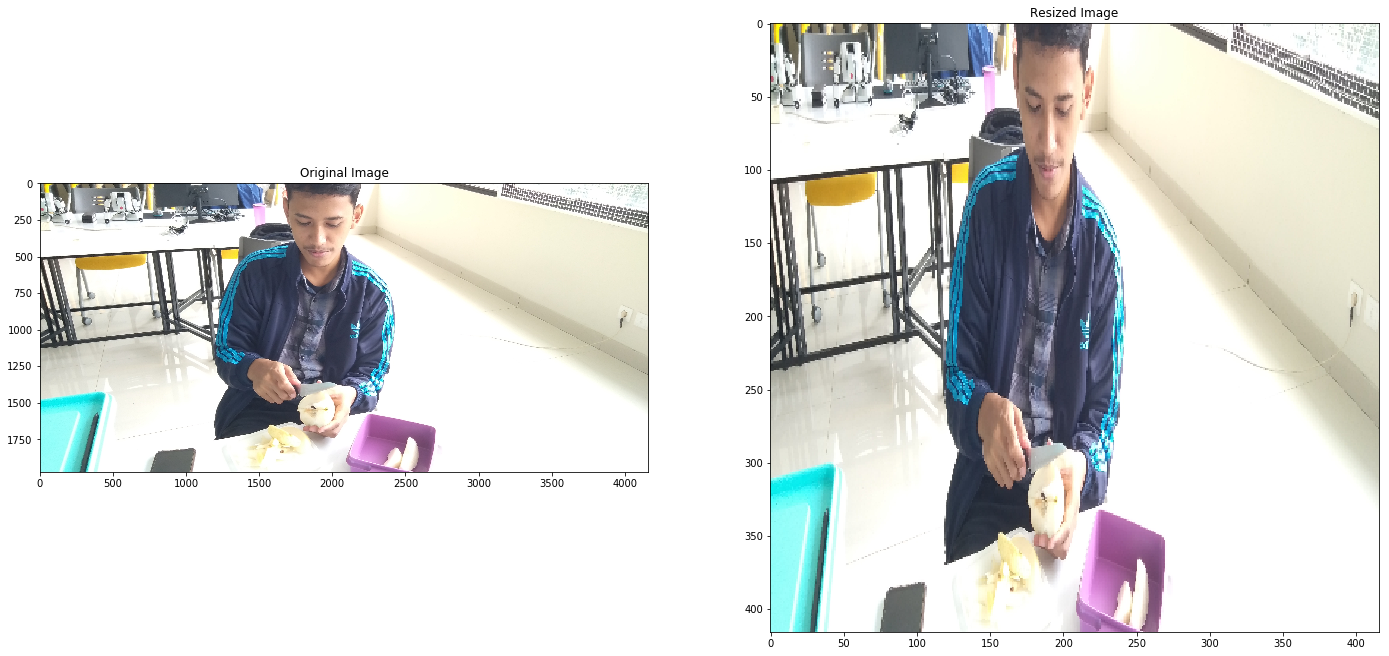

In [4]:
# Mengatur ukuran gambar
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Memasukkan contoh gambar, untuk di deteksi objek apa saja yg ada di dalam gambar tersebut
# Jangan lupa lokasi file nya harus sesuai dengan destinasi folder nya
img = cv2.imread('C:/Users/asus/Anaconda3/Dhoni/my project/sample gambar/tes1.jpg')

# konversi format image (.jpg) menjadi format RGB agar dapat diproses oleh model arsitektur yg sudah dibuat
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mengubah ukuran gambar ke lebar dan tinggi input dari lapisan pertama neural network.
resized_image = cv2.resize(original_image, (m.width, m.height))

# Melihat hasil konversi dari ukuran gambar nya
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

**Mengatur Non-Maximal Suppression Threshold**

Karena YOLO menggunakan Non-Maximal Suppression (NMS) untuk menyimpan kotak pembatas. Langkah pertama di NMS adalah dengan menghapus semua kotak pembatas yang diprediksi memiliki probabilitas deteksi kurang dari ambang batas NMS yang diberikan. Pada kode di bawah ini, ditetapkan ambang NMS menjadi 0,6. Ini berarti bahwa semua kotak pembatas yang diprediksi memiliki kemungkinan deteksi kurang dari 0,6 akan dihapus.

In [5]:
# mengatur ambang batas NMS threshold menjadi 0,6
nms_thresh = 0.6 

**Mengatur Intersection Over Union Threshold**

Setelah menghapus semua kotak pembatas yang diprediksi memiliki probabilitas deteksi rendah, langkah kedua di NMS yaitu memilih kotak pembatas dengan probabilitas deteksi tertinggi dan menghilangkan semua kotak pembatas yang nilai Intersection Over Union (IOU) lebih tinggi dari yang diberikan Ambang batas IOU. Pada kode di bawah ini, ditetapkan ambang IOU menjadi 0,4. Ini berarti bahwa semua kotak pembatas yang diprediksi memiliki nilai IOU lebih besar dari 0,4 akan dihapus.

In [6]:
# mengatur ambang batas IOU threshold menjadi 0,4
iou_thresh = 0.4

**Pendeteksian objek**

Setelah gambar dimuat dan diubah ukurannya, serta telah diatur parameter untuk nms_thresh dan iou_thresh, selajutnya kita dapat menggunakan algoritma YOLO untuk mendeteksi objek dalam gambar. mendeteksi objek menggunakan fungsi detect_objects (m, resized_image, iou_thresh, nms_thresh) dari modul utils. Fungsi ini mengambil model m yang dikembalikan oleh Darknet, gambar yang diubah ukurannya, dan ambang NMS dan IOU, serta mengembalikan kotak pembatas dari objek yang ditemukan.

Setiap kotak pembatas berisi 7 parameter: koordinat (x, y) dari pusat kotak pembatas, lebar w * dan tinggi * h dari kotak pembatas, tingkat akurasi deteksi, probabilitas kelas objek, dan id kelas objek.
Fungsi detect_objects() juga mencetak waktu yang dibutuhkan algoritma YOLO untuk mendeteksi objek dalam gambar dan jumlah objek yang terdeteksi.

Setelah kita memiliki kotak pembatas dari objek yang ditemukan oleh YOLO, kita dapat mencetak kelas dari objek yang ditemukan dan probabilitas kelas objek yang sesuai. Untuk melakukan ini dapat digunakan fungsi print_objects() di modul utils.

Terakhir, digunakan fungsi plot_boxes() untuk memplot kotak pembatas dan label kelas objek terkait yang ditemukan oleh YOLO pada gambar yg di input. Jika kita mengatur flag plot_labels ke False, maka akan menampilkan kotak pembatas tanpa label. Ini membuatnya lebih mudah untuk melihat kotak pembatas jika nms_thresh nya terlalu rendah. Fungsi plot_boxes() digunakan untuk memplot kotak pembatas dari kelas objek yang sama. Namun, jika kita ingin semua kotak pembatas memiliki warna yang sama, maka dapat menggunakan kata kunci color untuk mengatur warna yang diinginkan. 

Kita juga dapat mengubah parameter iou_thresh dan nms_thresh untuk melihat bagaimana pengaruhnya terhadap algoritma pendeteksian YOLO. Nilai default iou_thresh = 0.4 dan nms_thresh = 0.6 bekerja dengan baik untuk mendeteksi objek dalam berbagai jenis gambar.



It took 18.804 seconds to detect the objects in the image.

Number of Objects Detected: 3 

Objects Found and Confidence Level:

1. person: 0.999998
2. chair: 0.989511
3. bowl: 0.997359


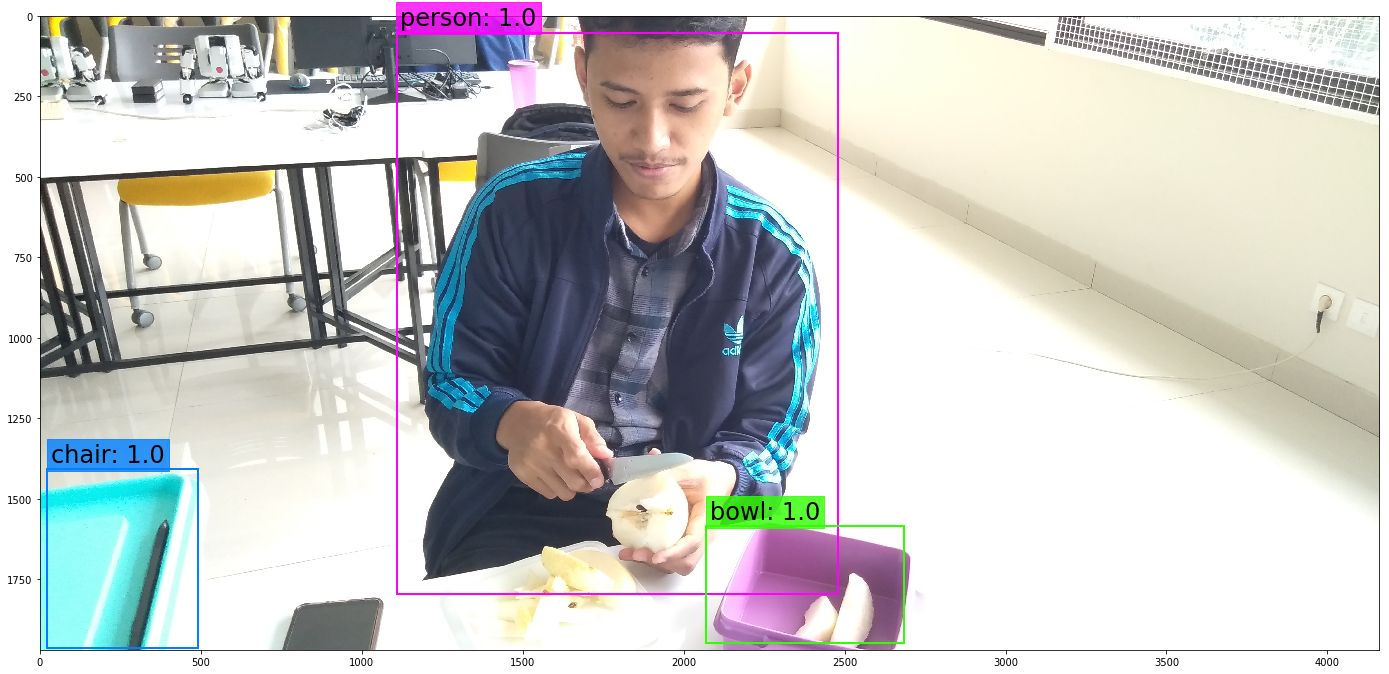

In [7]:
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Mencetak objek yg terdeteksi dan mencetak tingkat akurasi nya
print_objects(boxes, class_names)

# membuat plot gambar dengan kotak pembatas dan label kelas objek yang sesuai
plot_boxes(original_image, boxes, class_names, plot_labels = True)

**Sample gambar lainnya**



It took 7.200 seconds to detect the objects in the image.

Number of Objects Detected: 28 

Objects Found and Confidence Level:

1. person: 0.999996
2. person: 1.000000
3. car: 0.707238
4. truck: 0.933031
5. car: 0.658085
6. truck: 0.666981
7. person: 1.000000
8. traffic light: 1.000000
9. person: 1.000000
10. car: 0.997369
11. bus: 0.998023
12. person: 1.000000
13. person: 1.000000
14. person: 1.000000
15. person: 1.000000
16. person: 1.000000
17. traffic light: 1.000000
18. traffic light: 1.000000
19. handbag: 0.997282
20. traffic light: 1.000000
21. car: 0.989741
22. traffic light: 1.000000
23. traffic light: 0.999999
24. person: 0.999999
25. truck: 0.715037
26. traffic light: 1.000000
27. person: 0.999993
28. person: 0.999996


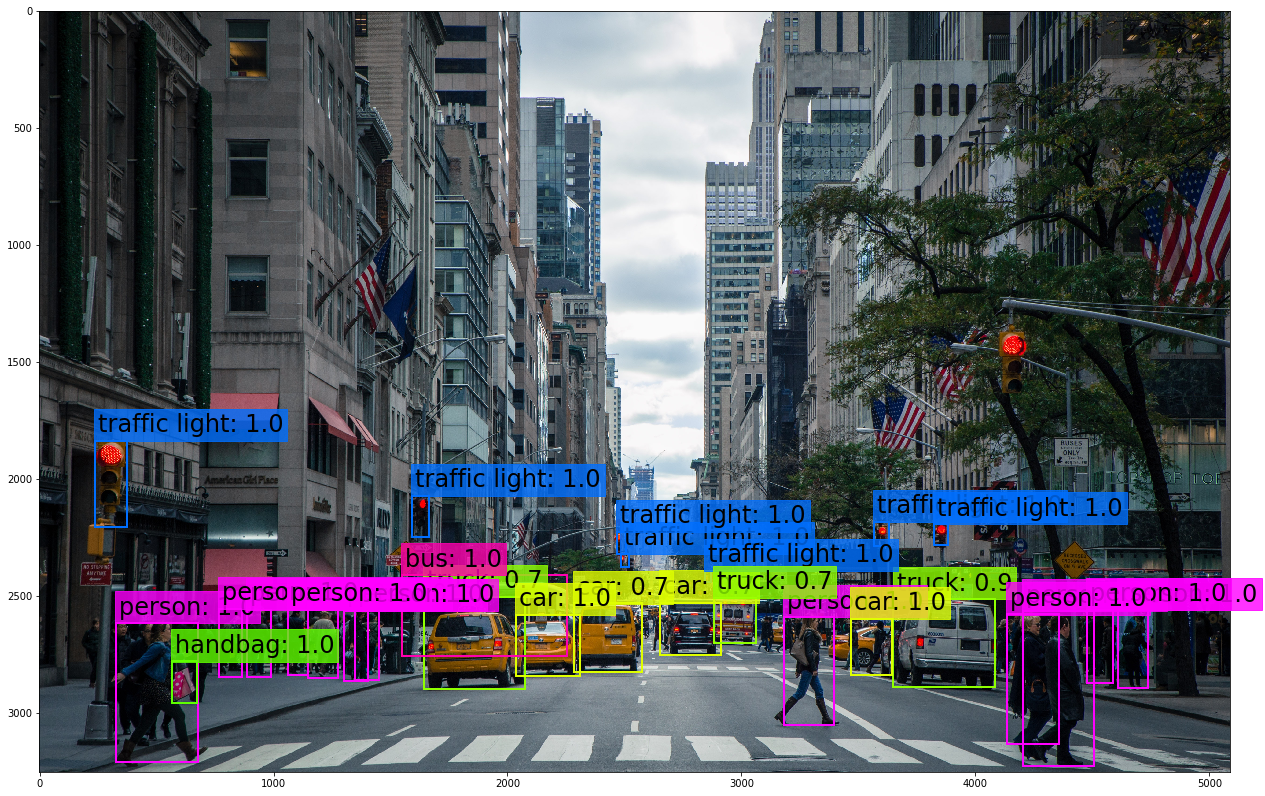

In [8]:
# Mengatur ukuran gambar
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Memasukkan contoh gambar, untuk di deteksi objek apa saja yg ada di dalam gambar tersebut
# Jangan lupa lokasi file nya harus sesuai dengan destinasi folder nya
img = cv2.imread('C:/Users/asus/Anaconda3/Dhoni/my project/sample gambar/tes2.jpg')

# konversi format image (.jpg) menjadi format RGB agar dapat diproses oleh model arsitektur yg sudah dibuat
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mengubah ukuran gambar ke lebar dan tinggi input dari lapisan pertama neural network.
resized_image = cv2.resize(original_image, (m.width, m.height))

# mengatur ambang batas NMS threshold menjadi 0,6
nms_thresh = 0.6 

# mengatur ambang batas IOU threshold menjadi 0,4
iou_thresh = 0.4

boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Mencetak objek yg terdeteksi dan mencetak tingkat akurasi nya
print_objects(boxes, class_names)

# membuat plot gambar dengan kotak pembatas dan label kelas objek yang sesuai
plot_boxes(original_image, boxes, class_names, plot_labels = True)

**Pembahasan Hasil**

Program Object detection dapat diterapkan ke berbagai bidang kehidupan sehari-hari, salah satunya dalam keramaian publik, hasil gambar dari CCTV dapat dideteksi oleh program objek detection dengan tujuan melihat track record objek apa saja yang telah melalui jalan/fasilitas publik tersebut. 

Contoh lainnya yaitu: Suatu bandar udara mengharuskan pengunjung yang datang untuk melakukan scanning terhadap barang bawaan mereka, tetapi proses scanning ini bisa menjadi kurang akurat karena berbagai faktor yang mungkin terjadi pada alat scan tersebut. Dengan menerapkan program object detection, barang bawaan pengunjung dapat dideteksi lebih akurat, serta dapat mengurangi potensi bahaya atau tindakan kriminal yang mungkin terjadi didalam pesawat. Supaya program dapat mendeteksi objek lebih banyak dan akurat, maka diperlukan database berupa image yang lebih besar lagi sesuai dengan kebutuhan penerapan nya. 

**Kesimpulan**

Program yang telah dibuat ini, merupakan prototype dari salah satu penerapan Object detection dibidang publik dan sistem keamanan. Dimana objek akan dideteksi oleh program (sistem neural network) untuk selanjutnya dilakukan proses pengenalan terhadap objek tersebut.

Sumber data dan referensi :
1. https://pjreddie.com/darknet/yolo/
2. https://ejournal.gunadarma.ac.id/index.php/tekno/article/view/1595

Disclaimer :
Banyak contoh code atau program untuk membuat object detection by image menggunakan Algoritma atau package YOLO, Opencv, tensorflow ataupun dengan mikrokontroler raspberry pi. Namun saya menggunakan cara dan data load yg berbeda sbg pembelajaran untuk saya pribadi dalam memahami setiap baris code atau program yg dibuat